In [8]:
from os.path import exists 
import pandas as pd
import shap
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *


task = "cyp2c9"

In [2]:
pd.read_csv(f"optimization/{task}/best.csv", comment="#").sort_values("val_mcc", ascending=False)

,model,val_accuracy,val_f1,val_mcc,false_negative_rate,false_positive_rate
3,CatBoost,0.84,0.77,0.65,0.23,0.120
5,XGBoost,0.84,0.77,0.65,0.20,0.140
0,SVC,0.83,0.77,0.64,0.16,0.170
6,XGBoost_thresh_0.3,0.83,0.77,0.64,0.15,0.180
2,LogisticRegression,0.82,0.75,0.62,0.18,0.180
1,RandomForest,0.82,0.73,0.60,0.25,0.150
4,KNN,0.78,0.61,0.47,0.48,0.095


# Data

In [3]:
# load thedataset
data = data_preprocessing(task)

# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)

# druglike molecules
data = select_druglike_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

# remove NaN values
data_nan = extract_null(data)
data = data.drop(data_nan.index)

display(data)

# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Dataset already exists, returning data/cyp2c9/raw_dataset.csv.
Number of molecules before druglikeliness selection: 12092
Number of druglike molecules: 11639


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1960010.0,12.820479,-0.183140,12.820479,0.128619,0.457873,362.476,344.332,...,0,0,0,0,0,0,1,0,0,0
1,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
2,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
3,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,644968.0,12.040635,-0.208718,12.040635,0.006714,0.728361,324.344,308.216,...,0,0,0,0,0,0,0,0,0,0
4,0,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,645164.0,13.082813,-0.044883,13.082813,0.018472,0.457249,495.628,458.332,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12087,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,16758814.0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0,0,0,0,0,0,0,0,0,0
12088,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,16758815.0,9.674588,-0.801690,9.674588,0.174259,0.635371,210.229,196.117,...,0,0,0,0,0,0,0,0,0,0
12089,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12090,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('int64'), dtype('float64')}


# XGBoost

In [6]:
file_loc = f"optimization/{task}/xgboost_0.csv"

# print comments
comments = ""
with open(file_loc, "r") as f:
    for line in f:
        if line[0] == "#":
            comments+=line

print(comments)

# print hyperparameter optimization results
pd.read_csv(file_loc, comment="#").drop("Unnamed: 0", axis=1).sort_values("val_mcc", ascending=False).head()

# fix_model_params={'objective': 'binary:logistic', 'eval_metric': 'aucpr'}
# main_metric=mcc
# model_params=[Integer(low=5, high=50, prior='uniform', transform='identity'), Real(low=0.01, high=0.2, prior='uniform', transform='identity'), Real(low=0.5, high=1, prior='uniform', transform='identity'), Real(low=1.0044411547002219, high=6, prior='uniform', transform='identity'), Real(low=0.5, high=1.0, prior='uniform', transform='identity'), Real(low=0.5, high=4.0, prior='uniform', transform='identity')]
# preprocessing_params=None



,max_depth,eta,subsample,scale_pos_weight,colsample_bytree,lambda,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
33,35,0.114662,0.714355,3.293693,0.916205,0.802231,0.021412,0.012791,0.022543,0.814540,0.841379,0.771144,0.746988,0.796915,0.650763,0.899536,0.792794
44,33,0.163251,0.721690,3.111631,0.915069,1.037549,0.021300,0.002738,0.027849,0.853239,0.840517,0.769039,0.747573,0.791774,0.648024,0.893441,0.781166
30,32,0.064919,0.619833,3.594999,0.715175,1.354825,0.022602,0.000822,0.009345,0.832115,0.837069,0.770909,0.729358,0.817481,0.647650,0.896789,0.792173
6,32,0.079414,0.827922,2.343335,0.913964,0.547117,0.018294,0.027003,0.024178,0.819920,0.840517,0.767880,0.750000,0.786632,0.646940,0.894208,0.797094
35,35,0.064582,0.647303,2.905274,0.584485,0.756221,0.021771,0.004747,0.017911,0.837105,0.839655,0.767500,0.746959,0.789203,0.645841,0.895905,0.801810


In [9]:
model = XGBClassifier(
    max_depth=35,
    eta=0.114662,
    subsample=0.714355,
    scale_pos_weight=3.293693,
    colsample_bytree=0.916205,
    reg_lambda=0.802231,
    objective="binary:logistic",
    eval_metric="aucpr",
)

data_prep = DataPreprocessing(
    feature_groups,
    var_threshold={
        "continuous": 0.021412,
        "discrete": 0.012791,
        "fingerprint": 0.022543,
    },
    corr_threshold=0.814540,
)


data_prep.fit(datasets["train"].drop("Y", axis=1), datasets["train"]["Y"])
x_train_prep = data_prep.transform(datasets["train"].drop("Y", axis=1))
x_val_prep = data_prep.transform(datasets["val"].drop("Y", axis=1))
x_test_prep = data_prep.transform(datasets["test"].drop("Y", axis=1))

model.fit(x_train_prep, datasets["train"]["Y"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.916205, early_stopping_rounds=None,
              enable_categorical=False, eta=0.114662, eval_metric='aucpr',
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.114661999,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=35,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

Accuracy: 84.14%
F1-score: 77.11%
Matthews correlation coefficient: 0.6507628870548022%


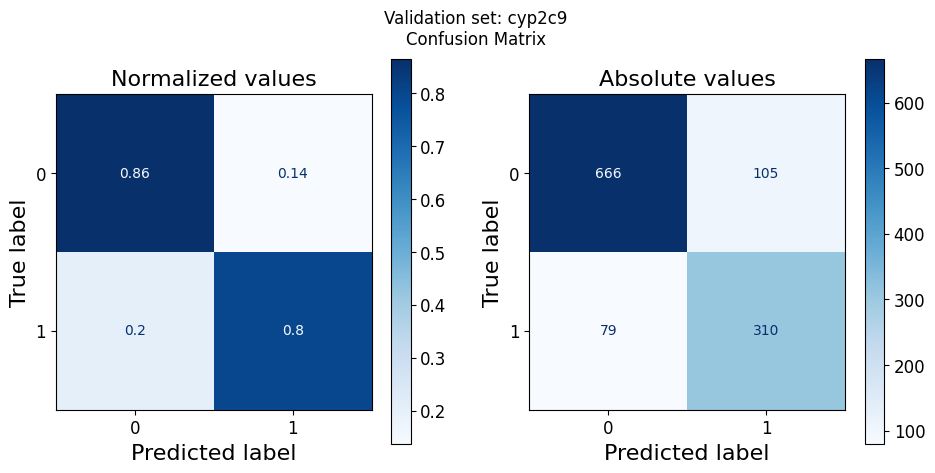

Accuracy: 83.45%
F1-score: 76.30%
Matthews correlation coefficient: 0.6365736519418054%


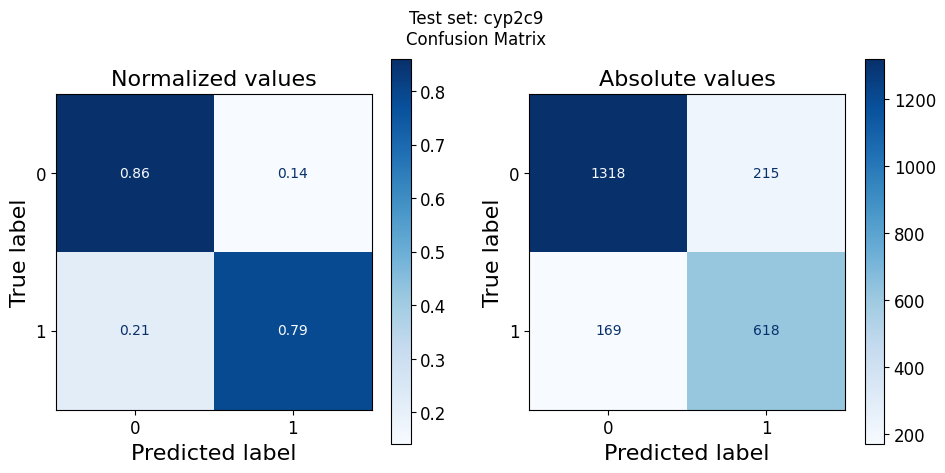

In [10]:
y_val_pred = model.predict(x_val_prep)
conf_matrix(datasets["val"]["Y"], y_val_pred, f"Validation set: {task}")

y_test_pred = model.predict(x_test_prep)
conf_matrix(datasets["test"]["Y"], y_test_pred, f"Test set: {task}")

## SHAP

In [14]:
# Add feature names to x_train_prep

data_norm = MinMaxScaler().fit_transform(datasets["train"].drop("Y", axis=1))
d1 = pd.DataFrame(data_norm, columns=datasets["train"].drop("Y", axis=1).columns)

d2 = pd.DataFrame(x_train_prep)
df = pd.concat([d2, d1], axis=1).T

x_train_prep_shap = df[df.duplicated()].T
model.fit(x_train_prep_shap, datasets["train"]["Y"])

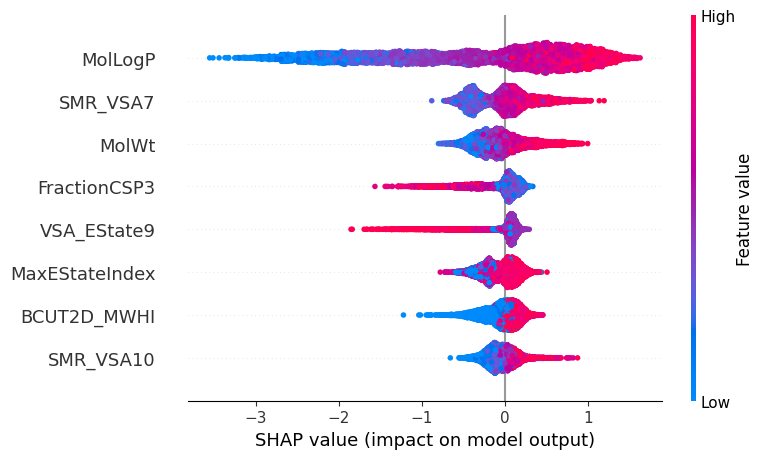

In [19]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model, check_additivity=False, feature_perturbation='interventional')
shap_values = explainer.shap_values(x_train_prep_shap, check_additivity=False)
shap.summary_plot(shap_values, x_train_prep_shap, max_display=8)